# 주식가격 예측

## 학습목표

- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

### 시계열 예측이란
- 미래를 예측한다는 것은 가능할까?
- Stationary한 시계열 데이터란?
- 시계열 데이터 사례 분석
- Stationary 여부를 체크하는 통계적 방법

### ARIMA 시계열 예측
- 시계열 예측의 기본 아이디어 : Stationary하게 만들 방법은 없을까?
- ARIMA 모델의 개념
- ARIMA 모델 훈련과 추론

# (1) ABBC-USD

In [194]:
# 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

### [ABBC-USD] 시계열데이터 준비

In [195]:
# data load
dataset_filepath = '~/aiffel/workplace/EX11_Stock_Price_Prediction/data/ABBC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,0.176931,0.182645,0.174477,0.178954,0.178954,45452430
2021-02-17,0.178949,0.180586,0.173004,0.173385,0.173385,43905146
2021-02-18,0.173388,0.182292,0.169164,0.175698,0.175698,42880816
2021-02-19,0.175687,0.176292,0.165355,0.172602,0.172602,43072185
2021-02-20,0.172721,0.173234,0.157037,0.158975,0.158975,40400651


In [196]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    0.178954
2021-02-17    0.173385
2021-02-18    0.175698
2021-02-19    0.172602
2021-02-20    0.158975
Name: Close, dtype: float64

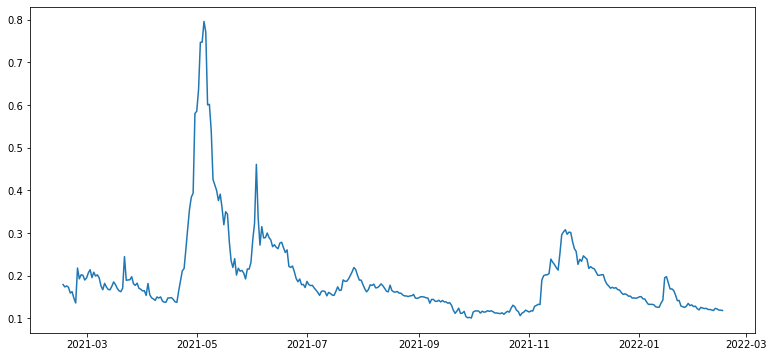

In [197]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

### [ABBC-USD] 전처리 

In [198]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [199]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


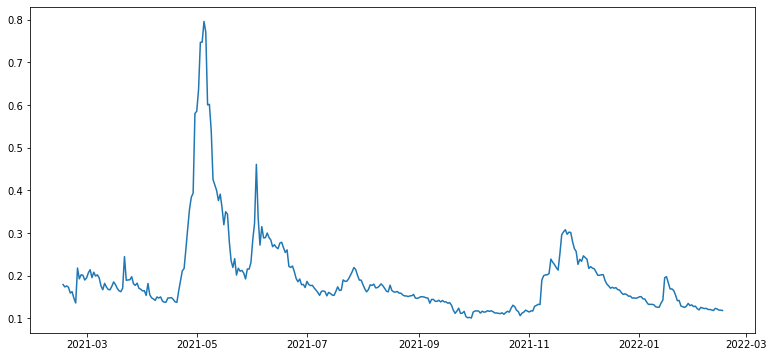

In [200]:
plt.plot(ts)

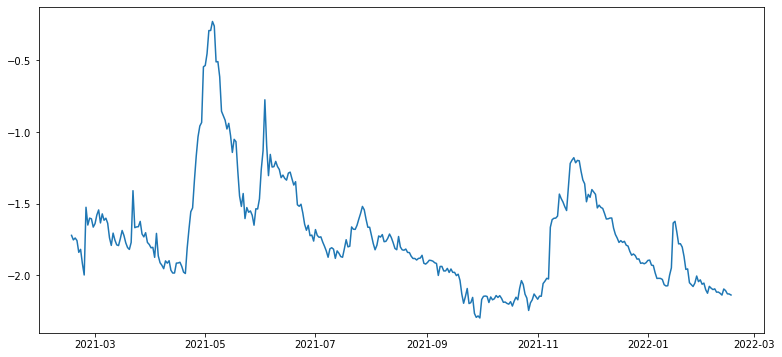

In [201]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### [공통] 시계열 안정성 분석
일정 시간내에서 구간 통계치(Rolling Statistics)를 시각화하는 함수이다.  
쉽게 말하자면 원본 시계열과 이동된 시계열을 비교해서 경향성을 더 뚜렷하게 보자는 의미다.  
만약 window가 12라면 시계열을 12만큼 옮겨서 비교하게 된다.  
그럼 과거 12개와 현재 12개가 비교되면서 변화를 눈으로 확인하기 쉬워진다.

In [202]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 사용하는 통계 패키지이다.  
여기서 사용하는 adfuller은 ADF라는 검정함수를 제공한다.  
ADF 검정은 쉽게 말해서 시계열 데이터가 안정적(stationary)인지 테스트 하는 방법이다.

In [203]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

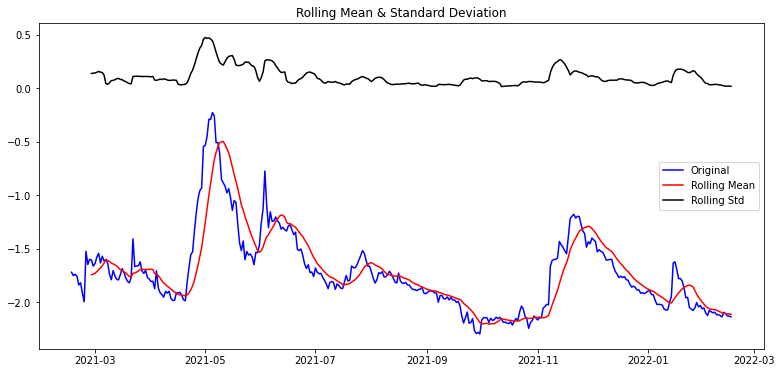

Results of Dickey-Fuller Test:
Test Statistic                  -2.916371
p-value                          0.043477
#Lags Used                       5.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64


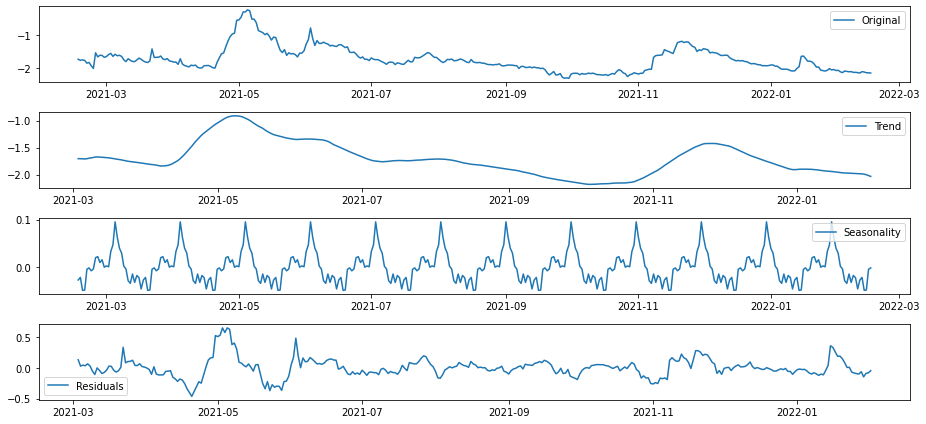

In [204]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [205]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.569070e+00
p-value                        8.020807e-09
#Lags Used                     1.700000e+01
Number of Observations Used    3.180000e+02
Critical Value (1%)           -3.451082e+00
Critical Value (5%)           -2.870672e+00
Critical Value (10%)          -2.571636e+00
dtype: float64


### [ABBC-USD] train, test dataset 생성

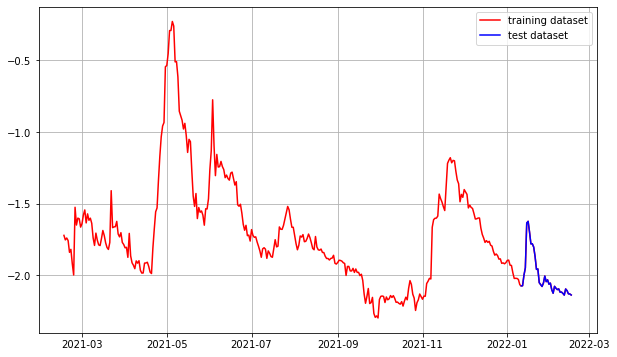

In [207]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
- 전처리가 끝다고 ARIMA 모델에 사용할 p, q 를 찾기 위해서 1차적으로 시범적인 모델을 찾는다.  
- 시범적인 모델을 찾기 위해서 아래에서 설명하고 있는 Graphical method를 사용하였다. 
- d 값은 차분된 데이터의 lag 값의 변화를 사용하여 결정하였다.
- 이 방법은 향후 진행할 Bitcoin과 Nasdaq지수의 예측에도 동일하게 사용하였다.

## 파라메터 추청 방법
- (step1) Autocorrelation을 사용해서 stationary한지 nonstationary 한지 판단을 진행하였다.
- (step2) 만약 nonstationary하다면 해당 데이터의 차분을 통해서 d 파라메터의 값을 추정하였다.
- (step3) 1차분에서 부족하다고 판단되면 2차분을 진행하였다. 분석한 모든 데이터는 2차분에서 안정적인 적으로 확인되었다.
- (step4) p, d, q 파라메터를 추정하고 해당 파라메터들을 조금씩 조정하며 AIC 값이 가장 최소화되는 조합을 찾아내었다.

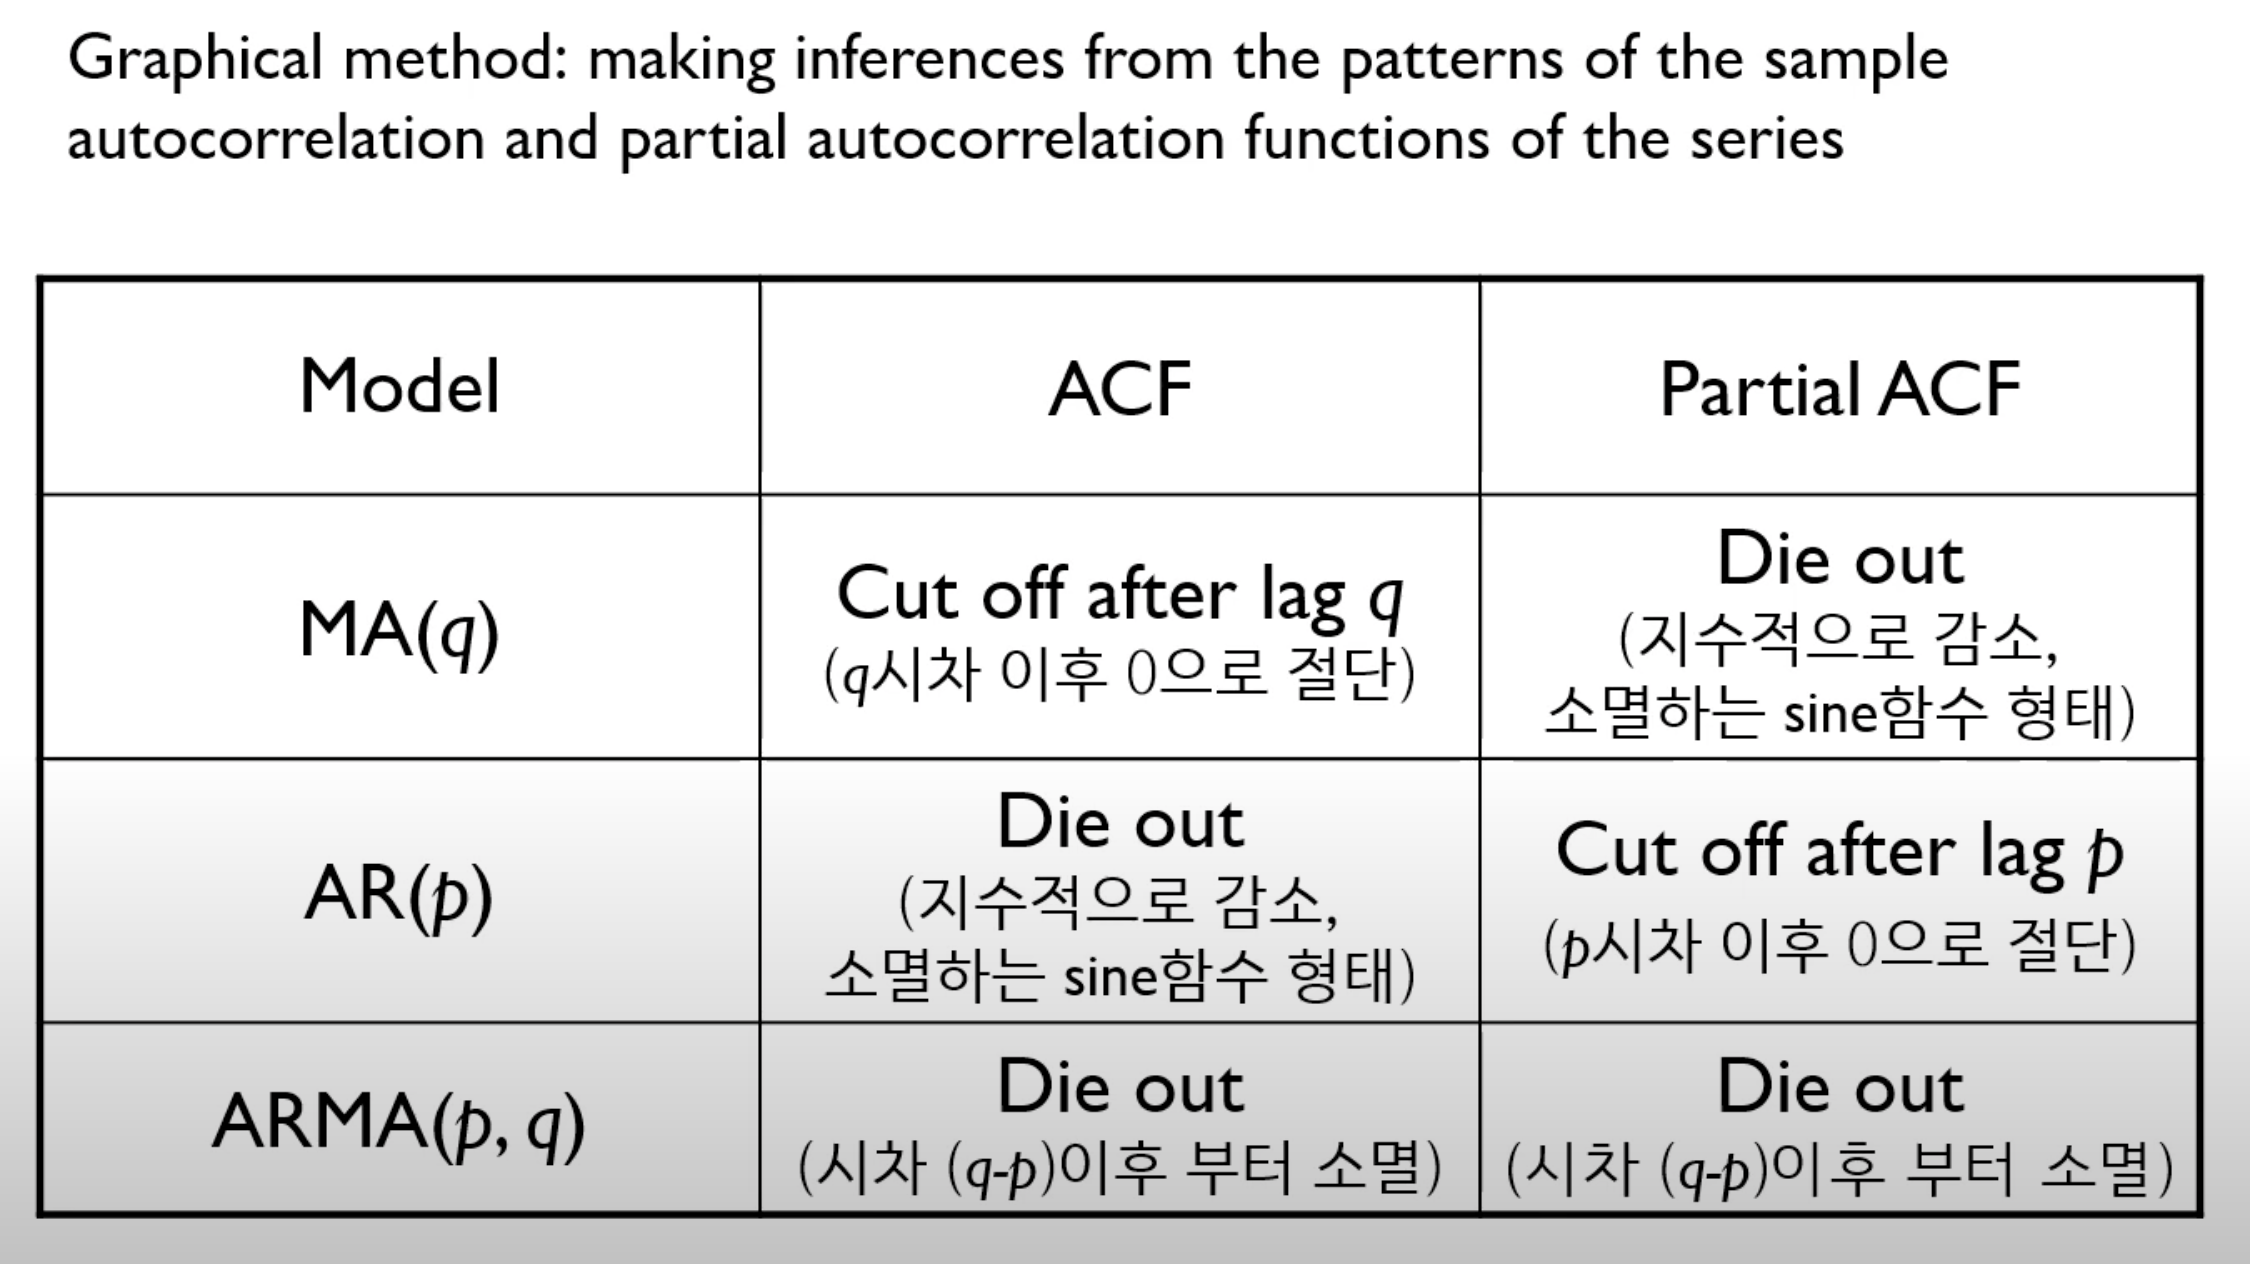

### [ABBC-USD] Autocorrelation을 사용한 데이터의 stationary / nonstationary  판단

### 판단결과: nonstationary
- Autocorrelation그래프를 보면 점차적으로 작아지는 경향을 보이고 있다.  
- 따라서 nonstationary 한 데이터로 판단되며 differencing이 필요할 것으로 판단된다.

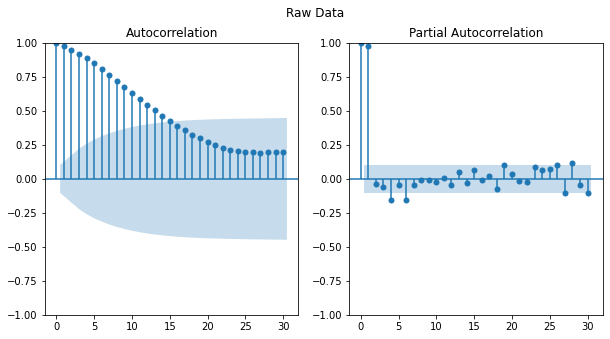

In [208]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(ts_log, lags=30, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(ts_log, lags=30, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

### [ABBC-USD] 차분(differencing) 구하기
- nonstationary로 판단되었기 때문에 차분(differencing)을 진행
- 1차 2차 차분을 모두 진행하고 안정적인 차분을 선택

Results of Dickey-Fuller Test:
Test Statistic                -6.580116e+00
p-value                        7.551240e-09
#Lags Used                     4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.138642e+01
p-value                        8.268808e-21
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


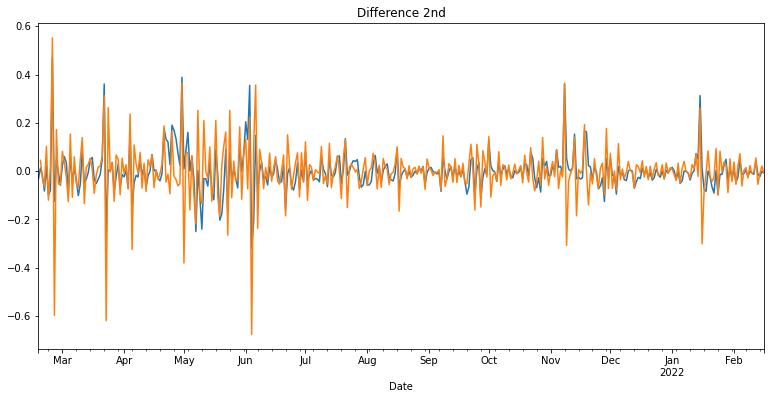

In [209]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### [ABBC-USD] 1차 차분된 데이터들의 Autocorrelation 확인

- 1차 차분된 데이터들의 Autocorrelation 그래프를 확인해 보면 stationary하게 변한 것을 확인 할 수 있다.
- Lag1 또는 Lag2 이후에 급격하게 떨어지는 형태가 보이지 않는다.  
- 그렇기 때문에 한번 더 차분을 진행해서 상태를 확인하도록 하자

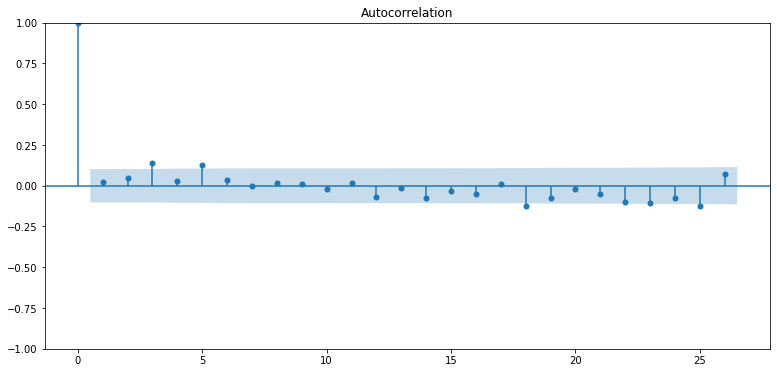

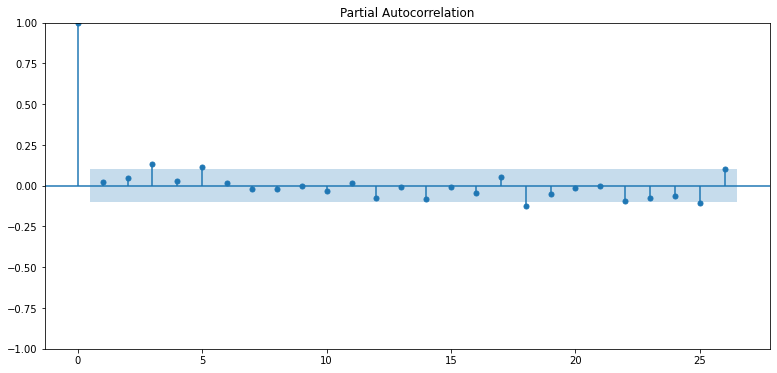

In [210]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### [ABBC-USD] 2차 차분된 데이터들의 Autocorrelation 확인, d=2
- 2차 차분된 데이터의 autocorrelation 그래프를 확인하면 Lag1 이후에 급격하게 확 떨어지는 형태의 데이터를 확인 할 수 있다.  
- Stationary하게 제대로 변한 것을 확인 할 수 있다.  
- 2차 차분을 해서 사용하기로 결정한다.  
- d = 2로 설정 할 것이다.

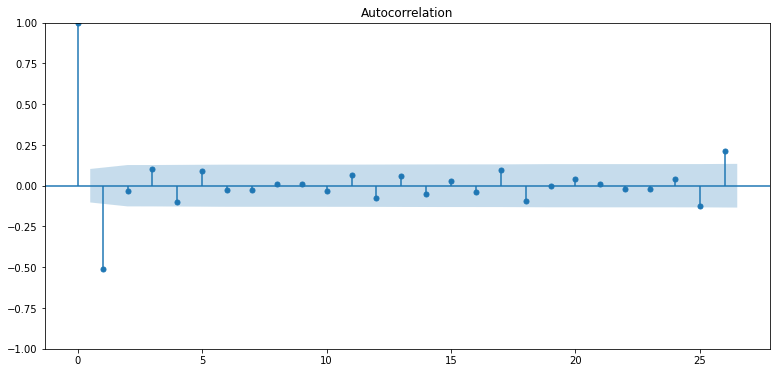

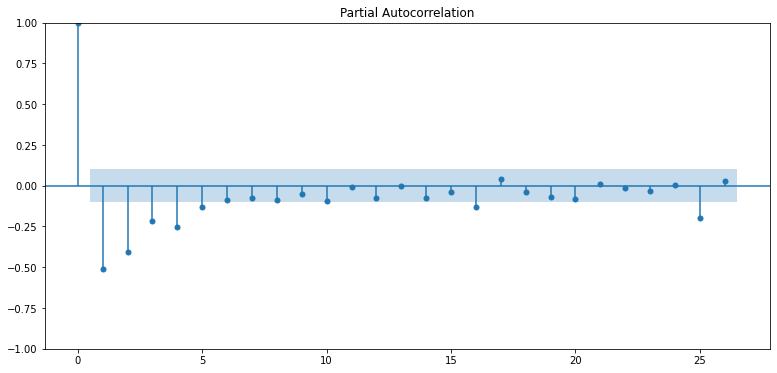

In [211]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### MA(q) 의 형태로 추정, q = 1
- Cutof after Lag 1  
- 지수적으로 감소, 소멸하는 sine함수의 형태

- Autocorrelation그래프에서는 Lag1 이후에 급격하게 감소한 것으로 보인다. 즉 Cutoff Lag1으로 볼 수 있다. 
- Partial Autocorrelation 그래프는 점진적으로 감소 하는 것으로 보아야 한다. 즉 Damped exponential dying down형태로 판단할 수 있다.  
- 따라서 이 데이터는 MA1 Model이 적합하다고 판단된다. (Box-Jenkins의 ARIMA Procedure에 따르면)  
- 따라서 ARIMA (0, 2, 1) 모델을 적용해 보기로 한다.

### [ABBC-USD] ARIMA 모델 훈련과 테스트, 기본 (0, 2, 1)

ACI는 모델의 정확도를 측정하는 수치로 작으면 작을 수록 정확하다.  
일단 그래프를 분석해서 나온 p, d, q를 기반으로 조절해서 가장 정확한 모델을 찾도록 하겠다.

(1) (0, 2, 1) 일때 AIC: -695.848  
(2) (0, 2, 2) 일때 AIC: -693.883  
(3) (0, 2, 3) 일때 AIC: -692.514  
(4) (0, 2, 4) 일때 AIC: -697.446  

위의 결과를 토대로 ARIMA 모델 (0, 2, 4)가 조금 더 좋다는 것을 판단 할 수 있습니다.

In [212]:
# Build Model

from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(train_data, order=(0, 2, 4))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(0, 2, 4)   Log Likelihood                 353.723
Date:                Thu, 17 Feb 2022   AIC                           -697.446
Time:                        12:18:34   BIC                           -678.496
Sample:                    02-16-2021   HQIC                          -689.884
                         - 01-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0034      6.529     -0.154      0.878     -13.800      11.793
ma.L2          0.0096      0.064      0.149      0.881      -0.116       0.135
ma.L3          0.1392      0.088      1.588      0.1

### [ABBC-USD] 모델 테스트 및 플로팅

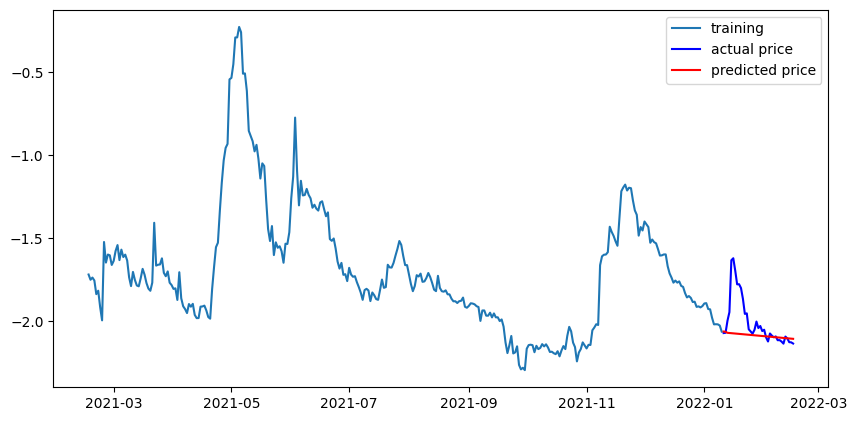

In [213]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)


plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### [ABBC-USD] 모델 예측정확도 8.15%

In [214]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0005651842733643264
MAE:  0.01329489960471499
RMSE:  0.02377360455135751
MAPE: 8.15%


# (2) BitCoin - USD

### [BitCoin-USD] 시계열데이터 준비

In [47]:
# data load
dataset_filepath = '~/aiffel/workplace/EX11_Stock_Price_Prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,47944.457031,50341.101563,47201.304688,49199.871094,49199.871094,77049582886
2021-02-17,49207.277344,52533.914063,49072.378906,52149.007813,52149.007813,80820545404
2021-02-18,52140.972656,52474.105469,51015.765625,51679.796875,51679.796875,52054723579
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132813,55888.132813,63495496918
2021-02-20,55887.335938,57505.226563,54626.558594,56099.519531,56099.519531,68145460026


In [48]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    49199.871094
2021-02-17    52149.007813
2021-02-18    51679.796875
2021-02-19    55888.132813
2021-02-20    56099.519531
Name: Close, dtype: float64

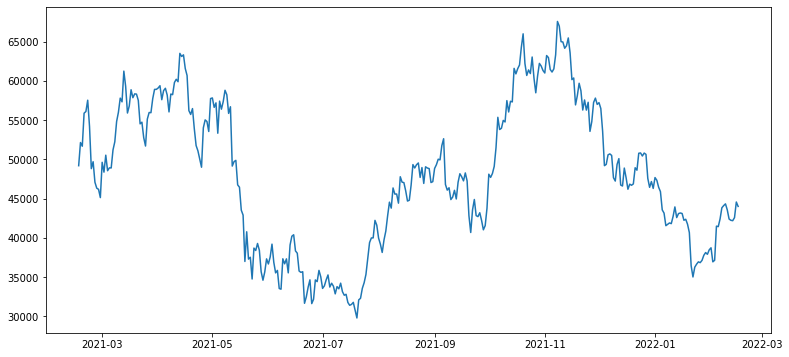

In [49]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

### [BitCoin-USD] 전처리 

In [50]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [51]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


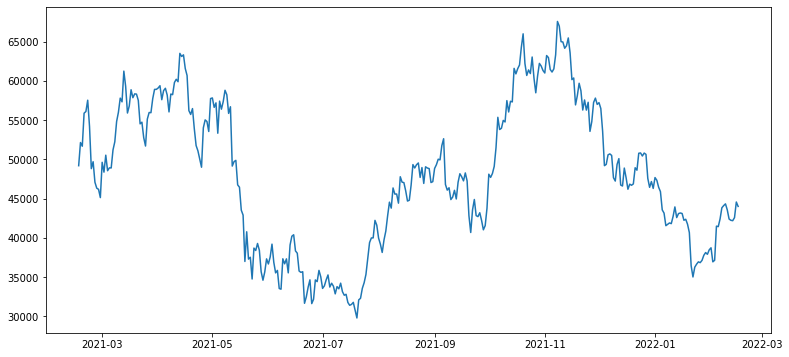

In [52]:
plt.plot(ts)

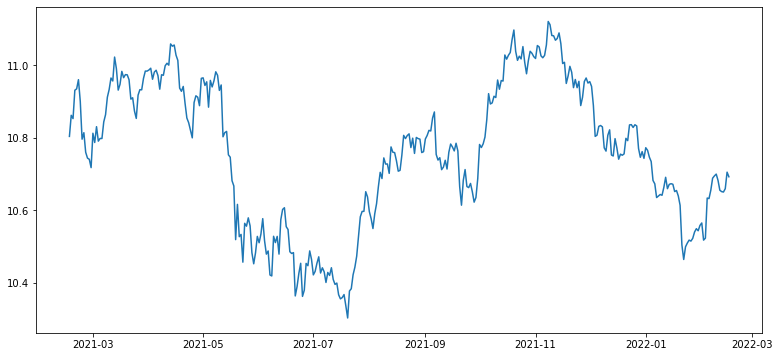

In [53]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

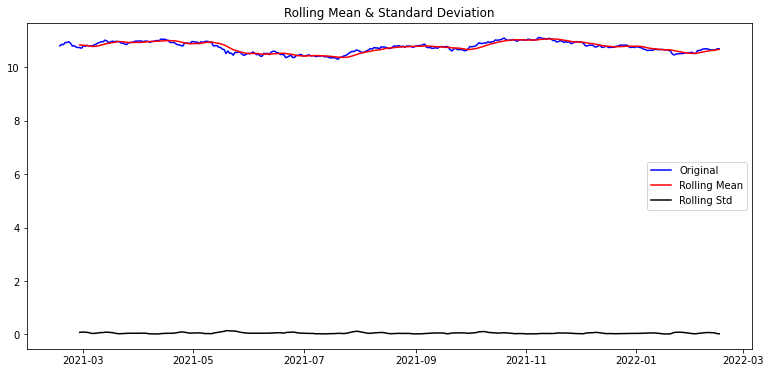

Results of Dickey-Fuller Test:
Test Statistic                  -1.871482
p-value                          0.345593
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


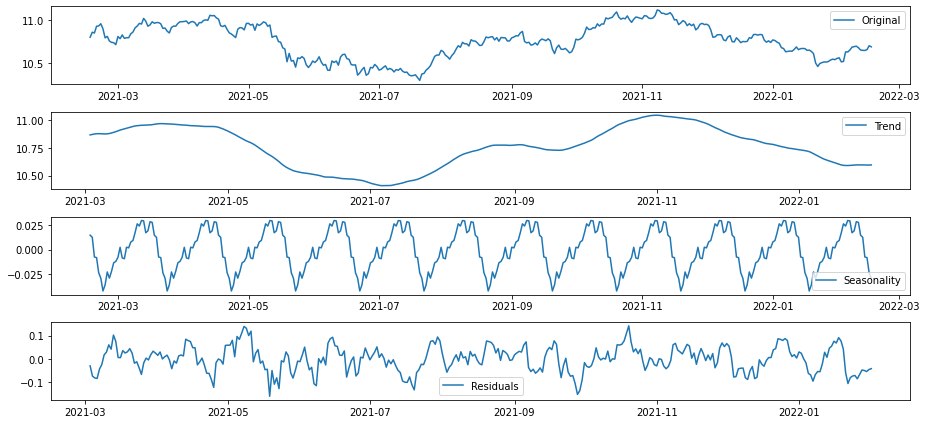

In [54]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [55]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.066696
p-value                          0.000016
#Lags Used                      12.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


### [BitCoin-USD] train, test dataset 생성

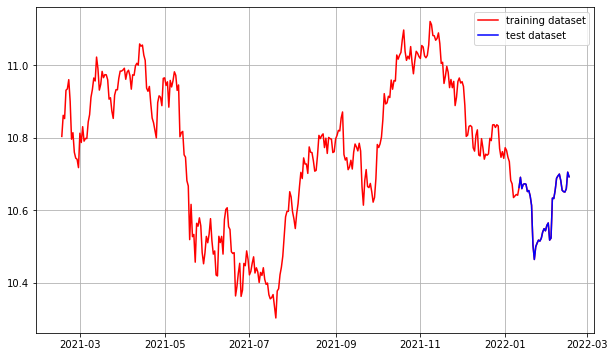

In [56]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


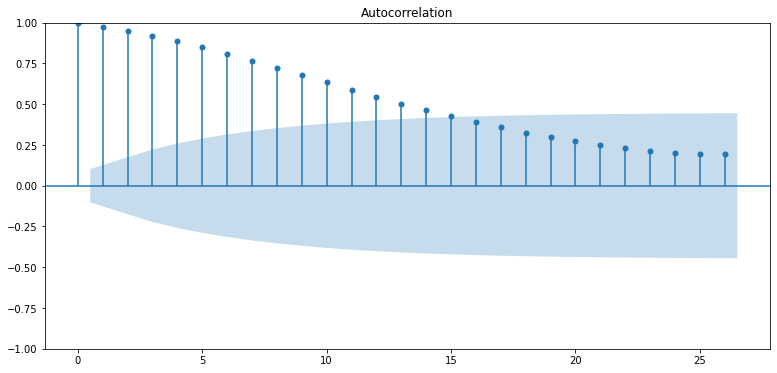

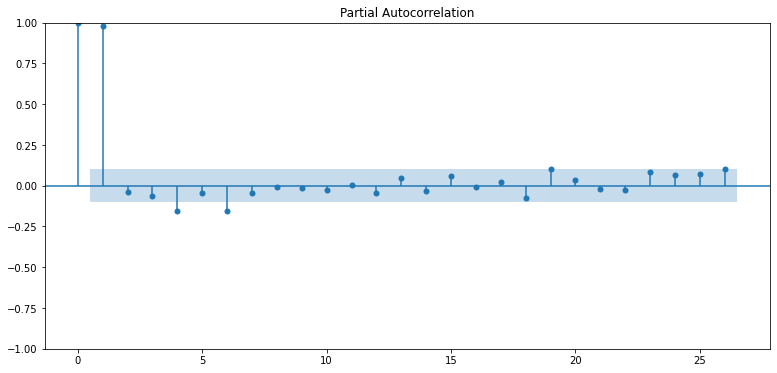

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.173047
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.208165e+00
p-value                        1.919634e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


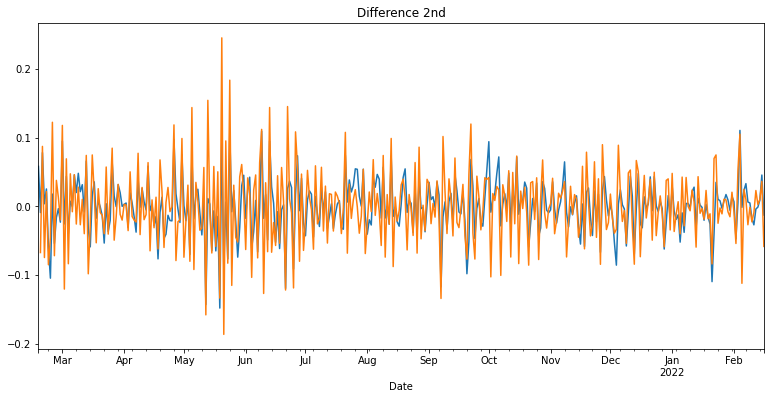

In [58]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### [BitCoin-USD] 1차 차분된 데이터들의 Autocorrelation 확인
- 1차 차분된 데이터들의 Autocorrelation 그래프를 확인해 보면 stationary하게 변한 것을 확인 할 수 있다.
- Lag1 또는 Lag2 이후에 급격하게 떨어지는 형태가 보이지 않는다.  
- 그렇기 때문에 한번 더 차분을 진행해서 상태를 확인하도록 하자

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


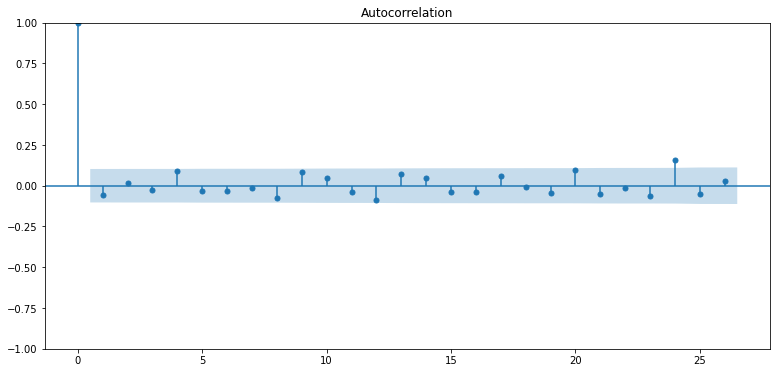

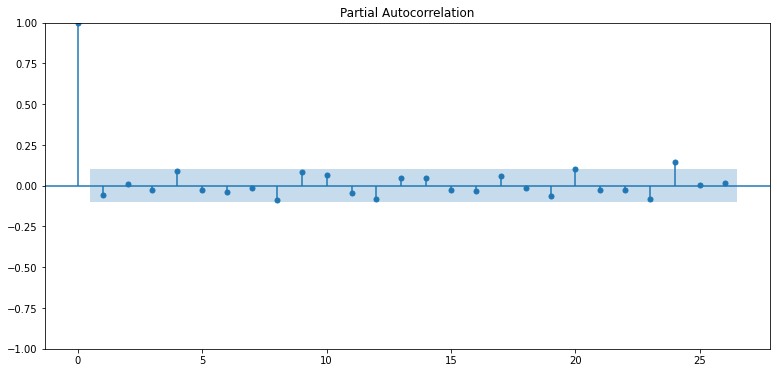

In [59]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### [BitCoin-USD] 2차 차분된 데이터들의 Autocorrelation 확인, d=2
- 2차 차분된 데이터의 autocorrelation 그래프를 확인하면 Lag1 이후에 급격하게 확 떨어지는 형태의 데이터를 확인 할 수 있다.  
- Stationary하게 제대로 변한 것을 확인 할 수 있다.  
- 2차 차분을 해서 사용하기로 결정한다.  
- d = 2로 설정 할 것이다.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


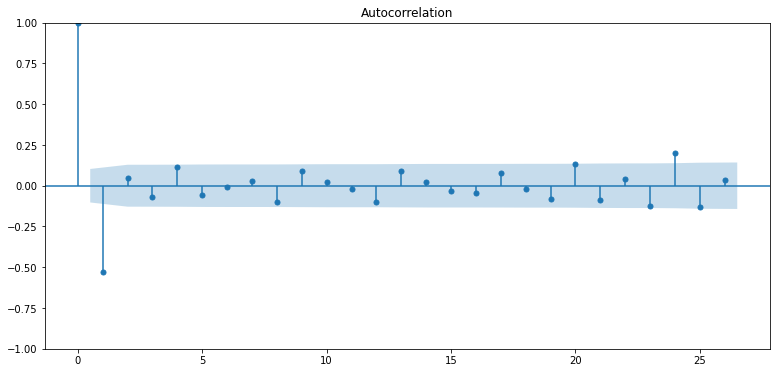

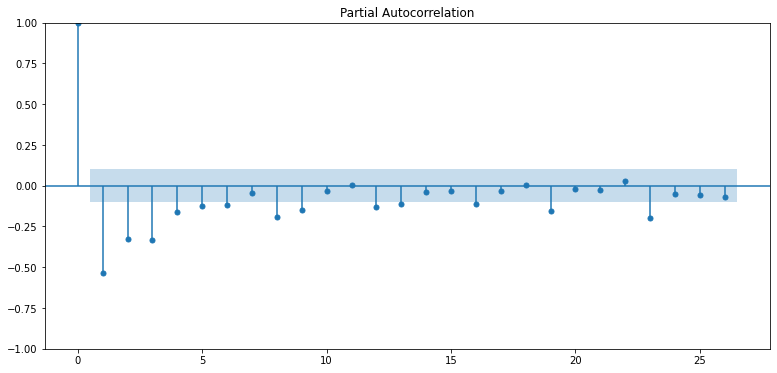

In [60]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### MA(q) 의 형태로 추정, q = 1
- Cutof after Lag 1  
- 지수적으로 감소, 소멸하는 sine함수의 형태

- Autocorrelation그래프에서는 Lag1 이후에 급격하게 감소한 것으로 보인다. 즉 Cutoff Lag1으로 볼 수 있다. 
- Partial Autocorrelation 그래프는 점진적으로 감소 하는 것으로 보아야 한다. 즉 Damped exponential dying down형태로 판단할 수 있다.  
- 따라서 이 데이터는 MA1 Model이 적합하다고 판단된다. (Box-Jenkins의 ARIMA Procedure에 따르면)  
- 따라서 ARIMA (0, 2, 1) 모델을 적용해 보기로 한다.

### [BitCoin-USD] ARIMA 모델 훈련과 테스트, 기본 (0, 2, 1)

ACI는 모델의 정확도를 측정하는 수치로 작으면 작을 수록 정확하다.  
일단 그래프를 분석해서 나온 p, d, q를 기반으로 조절해서 가장 정확한 모델을 찾도록 하겠다.

(1) (0, 2, 1) 일때 AIC: -1175.503  
(2) (0, 2, 2) 일때 AIC: -1175.098  
(3) (0, 2, 3) 일때 AIC: -1173.289  
(4) (0, 2, 4) 일때 AIC: -1171.393  

위의 결과를 토대로 보면 예측한대로 ARIMA 모델 (0, 2, 1)이 가장 좋은 것으로 판단된다.

In [61]:
# Build Model

from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(train_data, order=(0, 2, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 589.752
Date:                Wed, 16 Feb 2022   AIC                          -1175.503
Time:                        11:37:57   BIC                          -1167.924
Sample:                    02-16-2021   HQIC                         -1172.479
                         - 01-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9989      0.082    -12.172      0.000      -1.160      -0.838
sigma2         0.0016      0.000     10.001      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.62   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


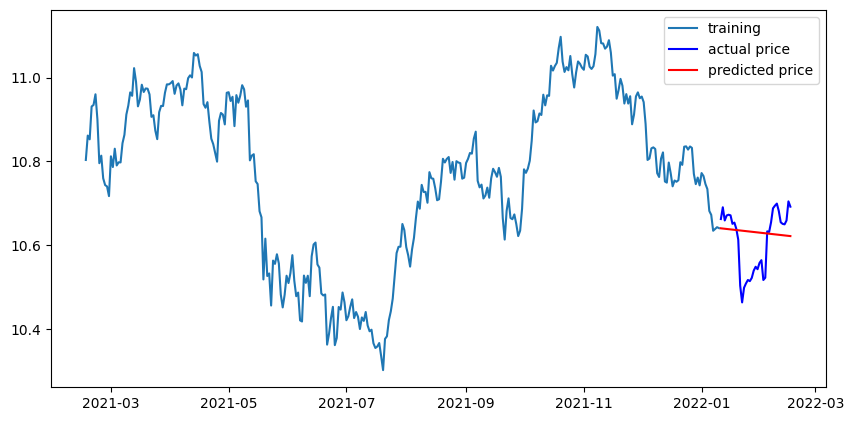

In [62]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### [BitCoin-USD] 모델 예측정확도 6.53%

In [63]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9272604.955922302
MAE:  2551.860850734275
RMSE:  3045.0952293684186
MAPE: 6.53%


# (3) NasDaq

### [NasDaq] 시계열데이터 준비

In [241]:
# data load
dataset_filepath = '~/aiffel/workplace/EX11_Stock_Price_Prediction/data/nasdaq.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,14152.209961,14175.120117,13995.450195,14047.500000,14047.500000,7646300000
2021-02-17,13911.650391,13976.429688,13804.259766,13965.490234,13965.490234,7227140000
2021-02-18,13814.669922,13905.959961,13714.349609,13865.360352,13865.360352,6454280000
2021-02-19,13929.200195,13985.580078,13842.599609,13874.459961,13874.459961,6686060000
2021-02-22,13714.200195,13757.059570,13530.959961,13533.049805,13533.049805,6435100000


In [216]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-16    14047.500000
2021-02-17    13965.490234
2021-02-18    13865.360352
2021-02-19    13874.459961
2021-02-22    13533.049805
Name: Close, dtype: float64

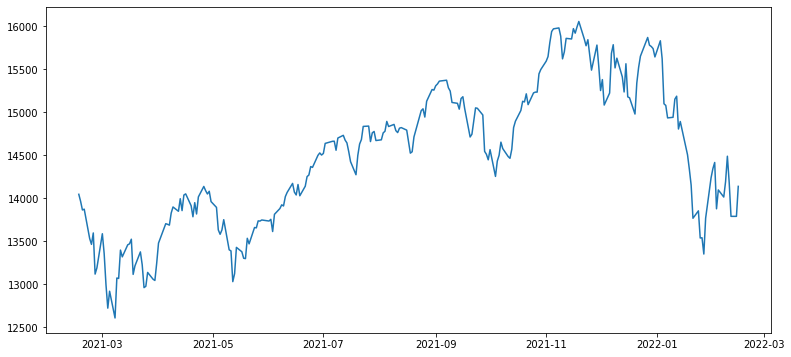

In [217]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

### [NasDaq] 전처리

In [218]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [219]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


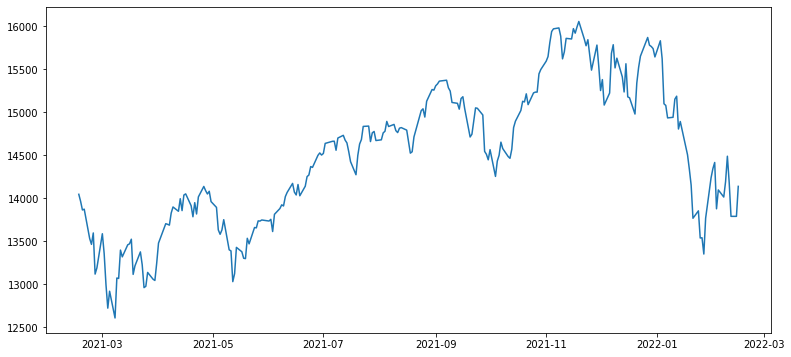

In [220]:
plt.plot(ts)

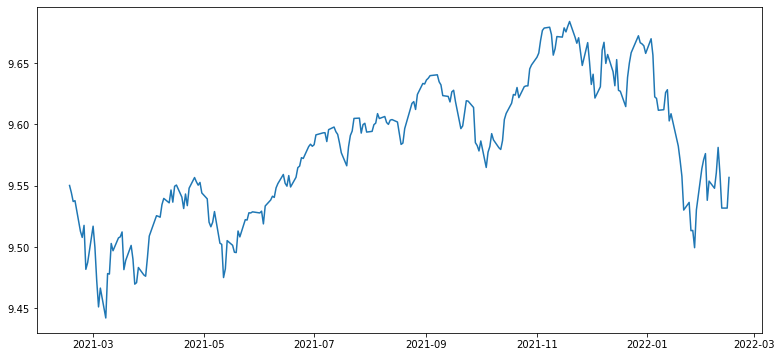

In [221]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

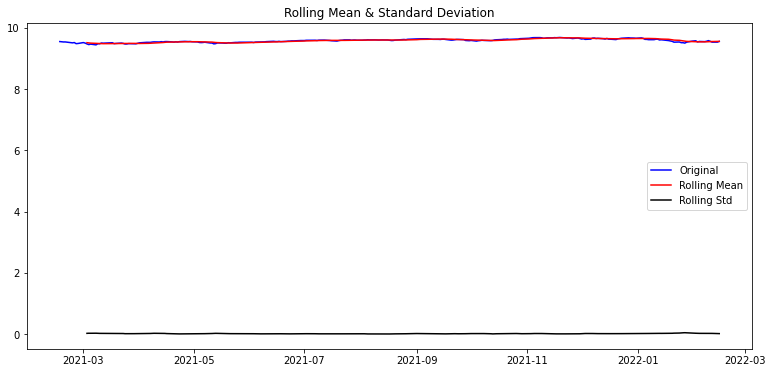

Results of Dickey-Fuller Test:
Test Statistic                  -1.757929
p-value                          0.401539
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


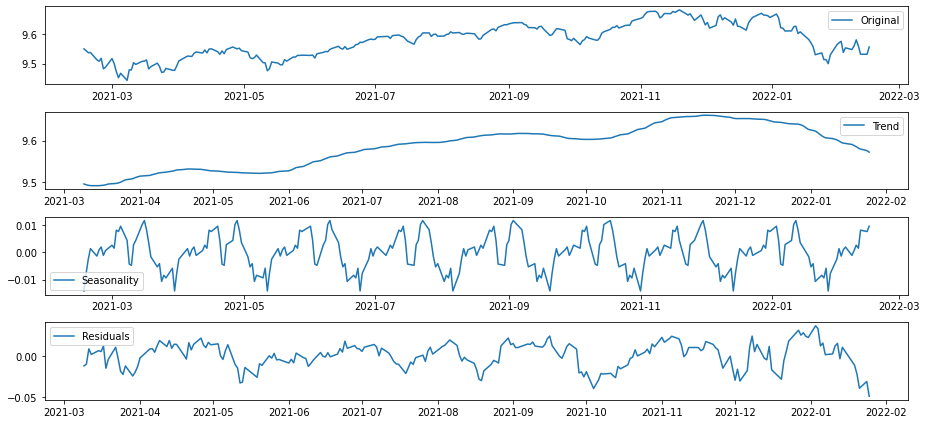

In [222]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [223]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.190732
p-value                          0.000009
#Lags Used                      14.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


### [NasDaq] train, test dataset 생성

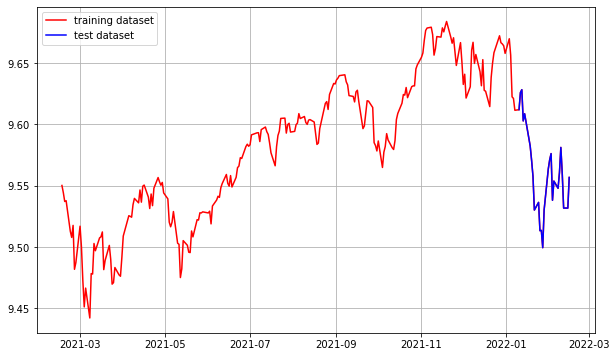

In [224]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기

### [NasDaq] Autocorrelation을 통한 테이터 타입 판단
Autocorrelation 결과 해당 데이터는 천천히 떨어지는 경향을 보이고 있다. 따라서 nonstationary 한 데이터로 판단되며
differencing이 필요할 것으로 판단된다.

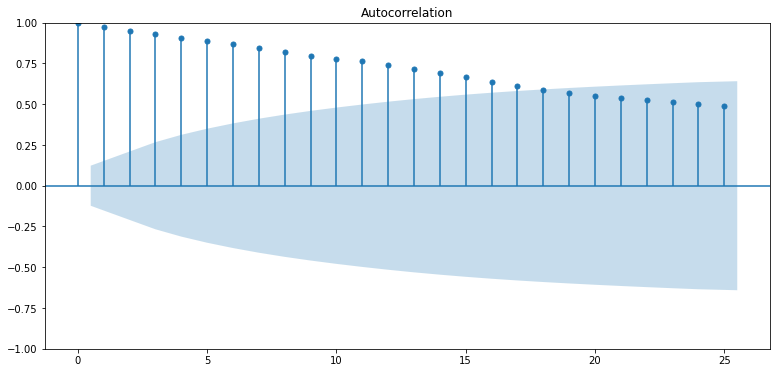

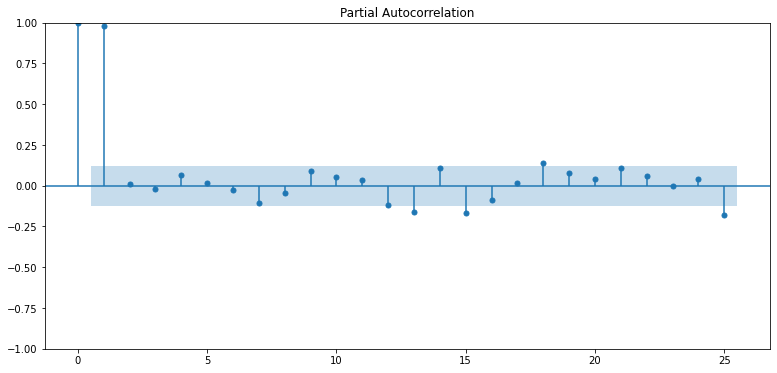

In [225]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### [NasDaq] 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.635344e+01
p-value                        2.917285e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.920644e+00
p-value                        3.732326e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


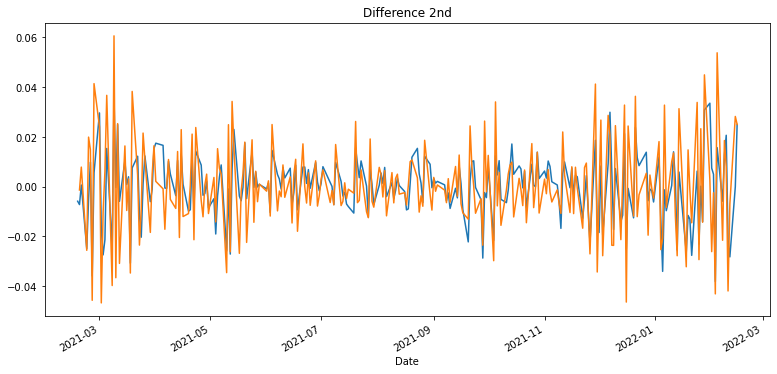

In [226]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### [NasDaq] 1차 차분된 데이터들의 Autocorrelation 확인
- 1차 차분된 데이터들의 Autocorrelation 그래프를 확인해 보면 stationary하게 변한 것을 확인 할 수 있다.
- Lag1 또는 Lag2 이후에 급격하게 떨어지는 형태가 보이지 않는다.  
- 그렇기 때문에 한번 더 차분을 진행해서 상태를 확인하도록 하자

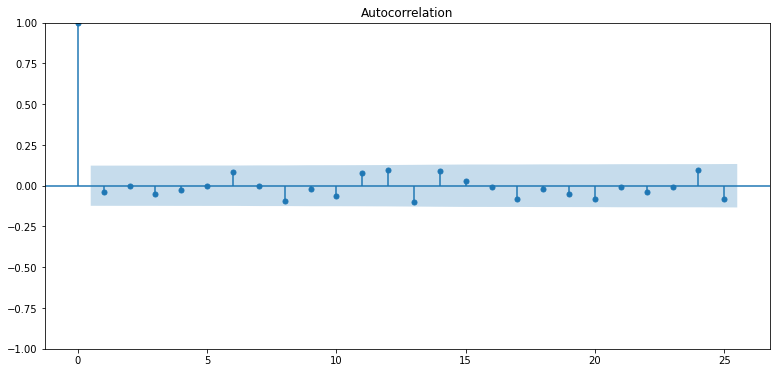

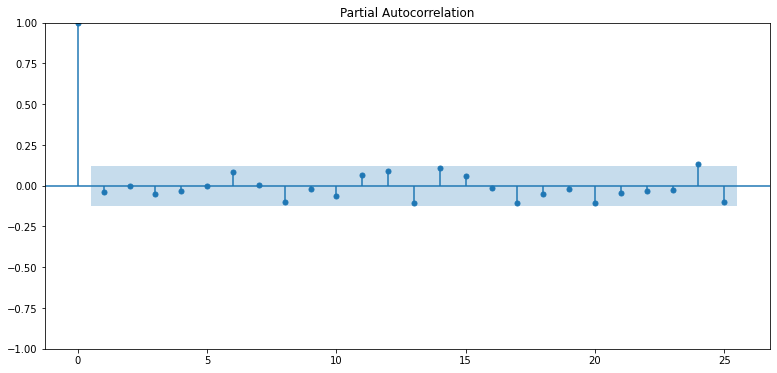

In [227]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### [NasDaq] 2차 차분된 데이터들의 Autocorrelation 확인, d=2
- 2차 차분된 데이터의 autocorrelation 그래프를 확인하면 Lag1 이후에 급격하게 확 떨어지는 형태의 데이터를 확인 할 수 있다.  
- Stationary하게 제대로 변한 것을 확인 할 수 있다.  
- 2차 차분을 해서 사용하기로 결정한다.  
- d = 2로 설정 할 것이다.

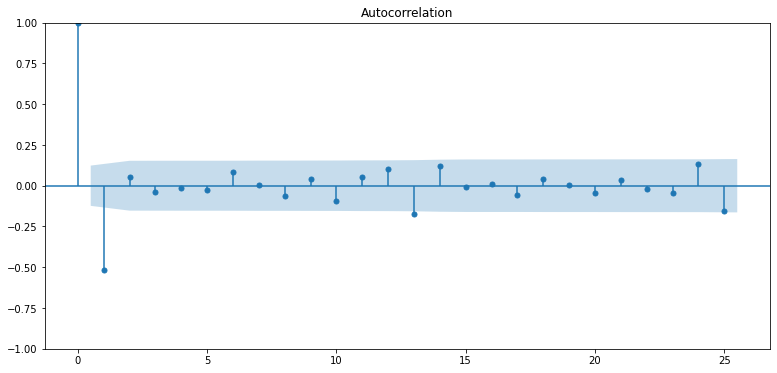

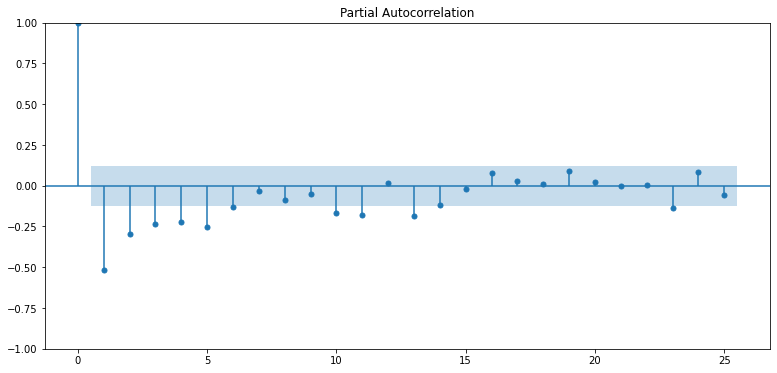

In [228]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### [NasDaq] ARIMA 모델 훈련과 테스트, 기본 (14, 2, 12)

ACI는 모델의 정확도를 측정하는 수치로 작으면 작을 수록 정확하다.  
일단 그래프를 분석해서 나온 p, d, q를 기반으로 조절해서 가장 정확한 모델을 찾도록 하겠다.

- (0, 2, 1) 일때 AIC: -1368.025 
- (0, 2, 2) 일때 AIC: -1368.033
- (0, 2, 3) 일때 AIC: -1358.744
- (0, 2, 4) 일때 AIC: -1363.971

위의 결과를 토대로 보면 예측한대로 ARIMA 모델 (0, 2, 2)이 가장 좋은 것으로 판단된다.

In [229]:
# Build Model

from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(train_data, order=(0, 2, 2))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 687.017
Date:                Thu, 17 Feb 2022   AIC                          -1368.033
Time:                        12:21:16   BIC                          -1357.772
Sample:                             0   HQIC                         -1363.892
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0684      0.460     -2.320      0.020      -1.971      -0.166
ma.L2          0.0690      0.072      0.965      0.334      -0.071       0.209
sigma2         0.0001   6.15e-05      2.125      0.0

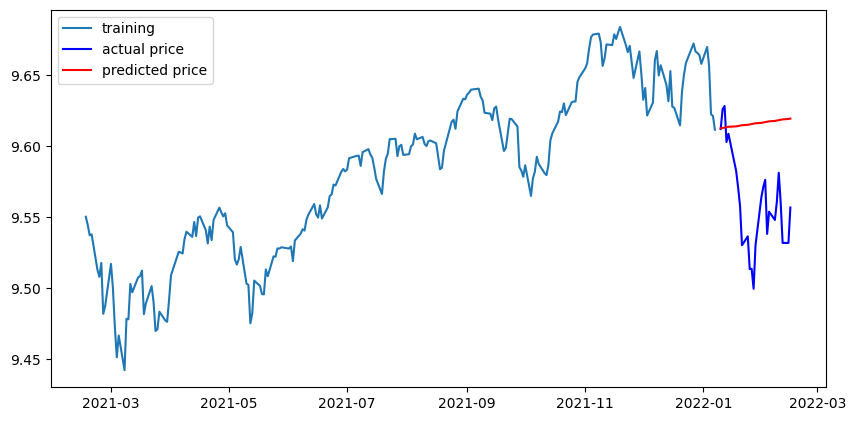

In [230]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### [NasDaq] 모델 예측정확도 %

In [231]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  882194.2540953963
MAE:  827.0120979365151
RMSE:  939.2519651804814
MAPE: 5.93%


# 회고

- 시계열 데이터를 다루는 기본적인 방법에 대해서 알 수 있어서 매우 좋은 기회였다.
- 원래 바로 앞에 진행했던 GAN 떄문에 이번 익스는 포기하려고 했었다. 
하지만 포기하고 그냥 대충하려고 본 내용이 너무 재미가 있었고 ARIMA 모델에 대해서 여러가지로 찾아 보면서 제대로 공부하게 되었다. 결국 좀더 좀더를 외치며 공부하다가. 제대로 해버린 느낌이다.
- 데이터는 주식이 아리나 평소에 관심있던 암호화폐 데이터를 사용했다. 야후 파이낸스에서 암호화폐 데이터도 제공을 해주었기 떄문에 가능했다.

- 위 내용에서도 언급했지만 ARIMA 모델의 파라메터들을 추청하는 방법이 주관적인 방법을 사용한 것이 좀 아쉽기는 하지만 해당방법을 사용했을 때 상당부분 예측이 잘 되었던 결과를 확인할 수 있었고 세 케이스 모두  MAPE 15% 미만의 정확도를 달성할 수 있었다

# 그러나

회고를 쓰고나서 계속 머리에 남는 것들이 있었다.  
왜 나스닥은 이상하게 그려지는 것일까?  
내가 놓친것이 대체 무엇일까?  
마음편히 제출하고 싶었지만  
이놈의 궁금증이 너무 강력하게 유발되어  
여러가지 분석 방법들을 찾아보던중에  
문들 머리를 스치는 것이  

내가 사용한 BOX-Jexkins ARIMA Procedure는 그래프를 해석할 때 주관적인 견해가 들어 갈 가능성이 높다고 한 말이 생각이 났다.  
만약 내가 그래프를 정확하게 해석하지 못하고 잘못 해석했다면?  
만약 이런 상황이면 모델 자체가 완벽하지 못하게 만들어지게 된다.  
어느정도 특성을 반영했으므로 대략적인 결과는 볼 수 있겠지만 아주 정확한 결과를 볼 수 없게 된다.  

그러한 해석의 불완전함으로 인해서 나스닥과 같은 결과가 나왔을 것이라고 예상하고  
다른 관점으로 해석을 해보기로 하였다.  

그래서 지금부터 시작할 것은 지금까지 내가 했던 것을 다른 관점으로 바라보면서  
해석을 진행할 것이다.  
물론 해석 방법은 앞에서 사용한 BOX-Jexkins ARIMA Procedure를 그대로 사용하되  
MA, AR의 p, q를 판별하기 위한 기준을 조금더 까다롭게 진행하겠다는 의미이다.


# [2차시기-재해석] ABBC-USD
- 두 번째로 진행하는 것이기에 코드 등등 불필요한 설명은 없이 진행하고 꼭 필요한 설명만 넣을 예정이다.
- 첫 번째 해석과 다른 점에 대해서는 자세하게 기술 할 예정이다
- 또한 위에서 진행한 방식 중 log를 취한 데이터를 사용하는 것은 하지 않기로 했다. 원래 데이터를 사용해서 하는 것이 더 정확하다는 결론을 내었다. 위 데이터로 실험한 결과 로그를 취하지 않은 원래 데이터로 실험한 결과가 더 정확한 모델을 만들었고 정확또 또한 굉장히 증가 하였다.

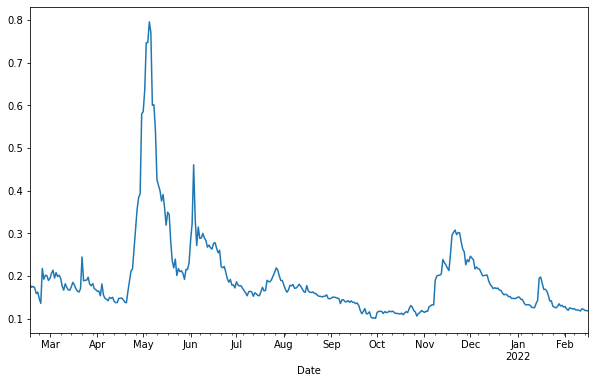

In [353]:
# 시계열 데이터 준비
dataset_filepath = '~/aiffel/workplace/EX11_Stock_Price_Prediction/data/ABBC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# 종가(close) 데이터만 사용
ts = df['Close']

# raw data plot
plt.figure(figsize=(10,6))
fig = ts.plot()

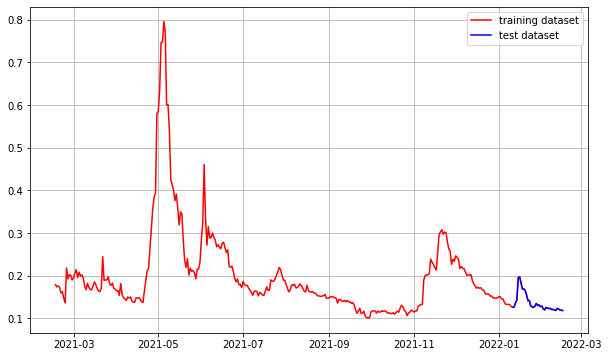

In [354]:
# train, test set 분할
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ts, test_size=0.1, shuffle=False)    

# 그래프로 확인
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

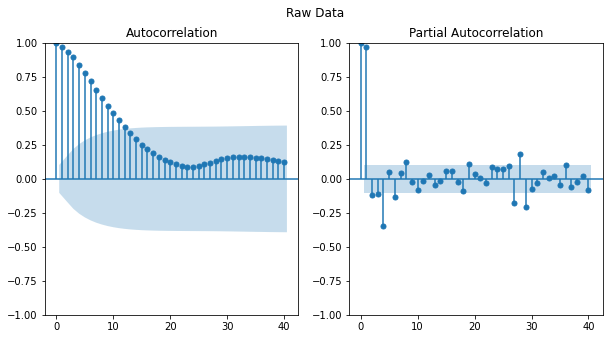

In [355]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(ts.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(ts.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

ACF 그래프를 통해서 nonstationary한 것을 확인하였다.  
srtationary 하게 변환하기 위해서 differencing을 진행할 예정이다.

In [356]:
# 1차 차분 및 데이터 확인

diff_1 = df.copy()
diff_1 = diff_1['Close'].diff()
diff_1 = diff_1.dropna()
print('####### Raw Data ######')
print(ts)
print('\n####### 1st Differenced Data ######')
print(diff_1)
print('\n')
augmented_dickey_fuller_test(diff_1)

# 2차 차분 및 차분데이터 확인
diff_2 = diff_1.diff()
diff_2 = diff_2.dropna()
print('\n####### 2dn Differenced Data ######')
print(diff_2)
print('\n')
print(augmented_dickey_fuller_test(diff_2))

####### Raw Data ######
Date
2021-02-16    0.178954
2021-02-17    0.173385
2021-02-18    0.175698
2021-02-19    0.172602
2021-02-20    0.158975
                ...   
2022-02-12    0.123093
2022-02-13    0.121694
2022-02-14    0.118985
2022-02-15    0.118884
2022-02-16    0.118023
Name: Close, Length: 366, dtype: float64

####### 1st Differenced Data ######
Date
2021-02-17   -0.005569
2021-02-18    0.002313
2021-02-19   -0.003096
2021-02-20   -0.013627
2021-02-21    0.003327
                ...   
2022-02-12    0.005138
2022-02-13   -0.001399
2022-02-14   -0.002709
2022-02-15   -0.000101
2022-02-16   -0.000861
Name: Close, Length: 365, dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -7.101423e+00
p-value                        4.158487e-10
#Lags Used                     6.000000e+00
Number of Observations Used    3.580000e+02
Critical Value (1%)           -3.448749e+00
Critical Value (5%)           -2.869647e+00
Critical Value (10%)          -2.571089e+00


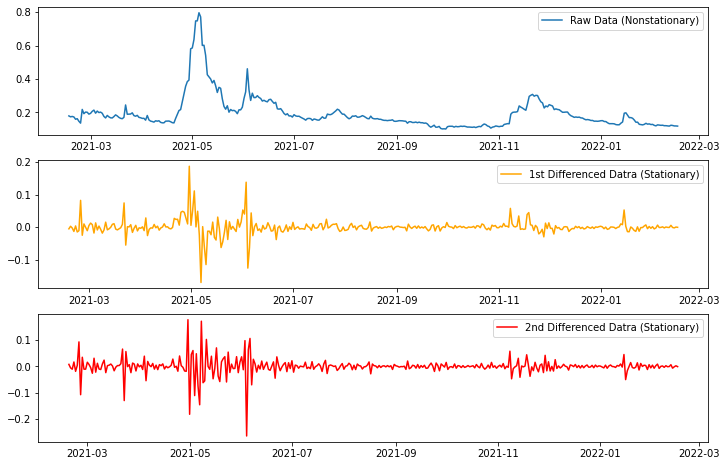

In [357]:
# 차분 데이터 시각화
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(df['Close'])
plt.legend(['Raw Data (Nonstationary)'])

plt.subplot(312)
plt.plot(diff_1, 'orange') # first difference (t - (t-1))
plt.legend(['1st Differenced Datra (Stationary)'])

plt.subplot(313)
plt.plot(diff_2, 'red') # first difference (t - (t-2))
plt.legend(['2nd Differenced Datra (Stationary)'])

plt.show()

확실히 1차 차분을 했는데도 불구하고 차분 전보다 차분을 한 경우에 데이터가 stationary하게 변경된 것을 확인 할 수 있다.

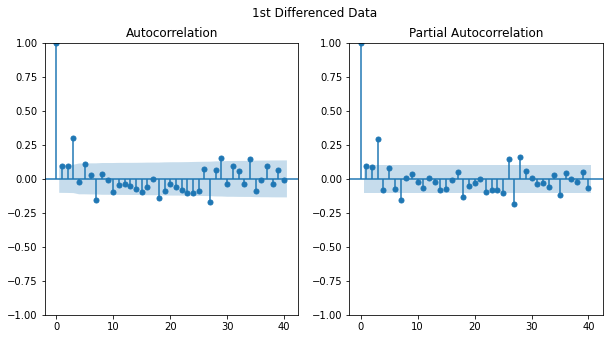

In [358]:
# 1차 차분 데이터의 ACF, PACF 그래프

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('1st Differenced Data')
sm.graphics.tsa.plot_acf(diff_1.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(diff_1.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

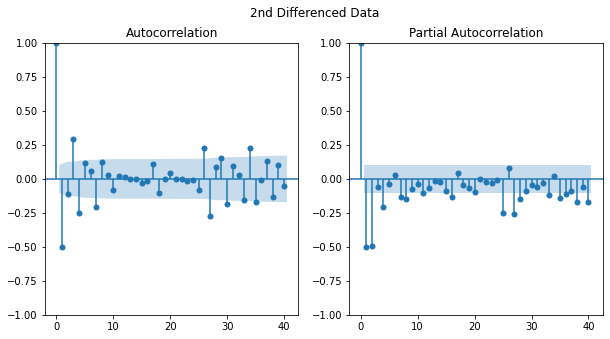

In [359]:
# 2차 차분 데이터의 ACF, PACF 그래프

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('2nd Differenced Data')
sm.graphics.tsa.plot_acf(diff_2.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(diff_2.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

### [NEW] auto_arima_model을 도입하여 p, d, q 확인
사실 p, d, q를 찾는 것이 생각보다 까다롭다. d 항목이야 차분의 수로 결정한다고 해도 사실 MA모델과 AR 모델을 구분하고 p, q 를 찾아 내는 것은 차분그래프의 형태나 추세를 주관적으로 분석해야 하다 보니 생각보다 까다로웠다. 그래서 이러한 과정을 좀더 손쉽게 진행 할 수 있는 방법을 찾았고 그 방법으로 SARIMA 모델과 auto arima 모델 두가지를 찾았다. SARIMA 모델의 경우는 seasonal을 제대로 확인해서 넣어야 하는 문제 때문에 사실 쓰기가 조금 어려운 점이 있었고 그래서 auto arima 모델을 사용해서 최적의 파라메터를 찾아 보았다.

In [360]:
# auto arima model을 사용한 최적 파라메터 찾기
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=4, seasonal=False,
                              d=2,
                              trace=True,
                              eooro_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1275.927, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-1459.244, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1456.775, Time=0.39 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-1459.671, Time=1.01 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-1482.207, Time=1.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1369.367, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-1465.772, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-1462.965, Time=0.85 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-1480.175, Time=2.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1458.617, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-1460.703, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-1469.291, Time=0.34 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-1473.731, Time=1.22 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-1457.654, Time=0.15 sec
 

In [361]:
# auto_arima_model 의 요약 
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  329
Model:               SARIMAX(3, 2, 1)   Log Likelihood                 747.468
Date:                Thu, 17 Feb 2022   AIC                          -1482.937
Time:                        13:06:15   BIC                          -1460.197
Sample:                             0   HQIC                         -1473.863
                                - 329                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -3.38e-05      0.000     -0.280      0.780      -0.000       0.000
ar.L1          0.1149      0.027      4.224      0.000       0.062       0.168
ar.L2          0.0732      0.041      1.803      0.071      -0.006       0.153
ar.L3          0.2638      0.041      6.487      0.000       0.184       0.343
ma.L1         -0.9443      0.026    -36.584      0.000      -0.995      -0.894
sigma2         0.0006   1.72e-05     36.482      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              7605.36
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### [NEW] auto_arima_model을 사용하서 찾아낸 p, d, q를 사용하여 test data를 사용하여 검증해 보았다.

In [362]:
# Build Model

from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(train_data, order=(3, 2, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 753.520
Date:                Thu, 17 Feb 2022   AIC                          -1497.039
Time:                        13:06:18   BIC                          -1478.090
Sample:                    02-16-2021   HQIC                         -1489.478
                         - 01-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0518      0.025      2.048      0.041       0.002       0.101
ar.L2          0.0546      0.035      1.570      0.116      -0.014       0.123
ar.L3          0.3123      0.037      8.479      0.0

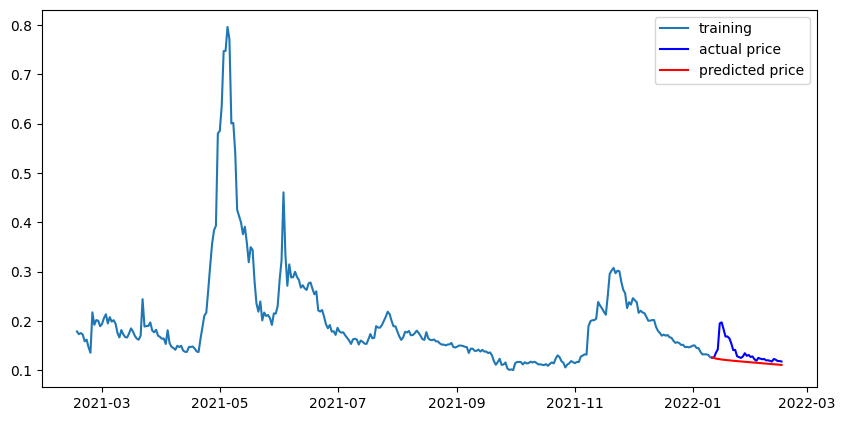

In [363]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [364]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0009512280798346756
MAE:  0.021042034599340665
RMSE:  0.030841985666209555
MAPE: 1.80%


## 첫번째 테스트의 MAPE: 8.15%
처음에 사용한 차분데이터를 사용해서 ACF PACF를 그려서 해당 그래프의 형태를 사용하여 추론한 방식에서는 정확도가 MAPE:8.15% 였다.

## 두번째 테스트의 MAPE: 1.80%
auto_arima_model을 사용하여 추정된 p, d, q를 사용하고 log를 취하지 않는 데이터를 사용하여 실험한 결과 MAPE는 1.80% 였다.
# 결론: 매우 유의미하게 MAPE가 개선된 것을 확인할 수 있다.

### 나머지도 그럴까? 아직 제출시간이 좀 남았으니 한번 해보자

# [2차시기-재해석] NasDaq

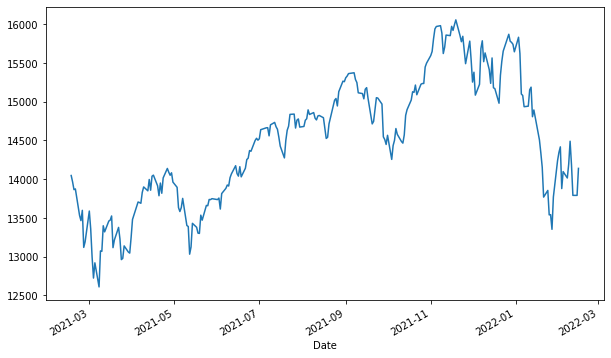

In [395]:
# 시계열 데이터 준비
dataset_filepath = '~/aiffel/workplace/EX11_Stock_Price_Prediction/data/nasdaq.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# 종가(close) 데이터만 사용
ts = df['Close']

# raw data plot
plt.figure(figsize=(10,6))
fig = ts.plot()

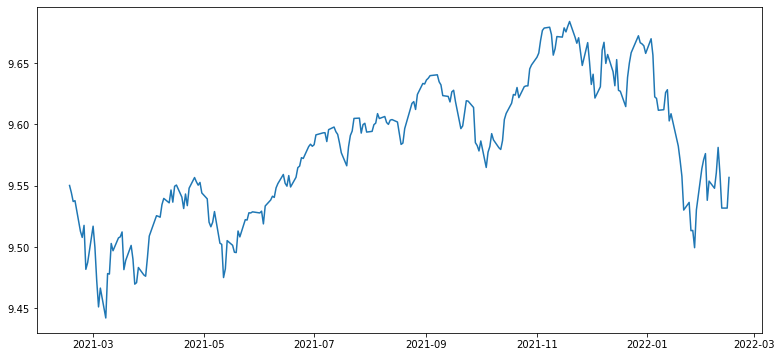

In [396]:
# log scale로 변환
ts = np.log(ts)
plt.plot(ts_log)

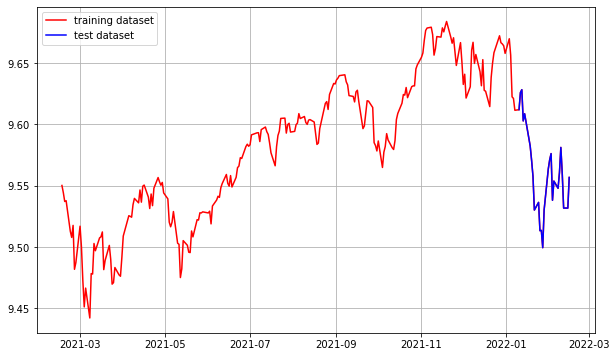

In [397]:
# train, test set 분할
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ts, test_size=0.1, shuffle=False)    

# 그래프로 확인
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

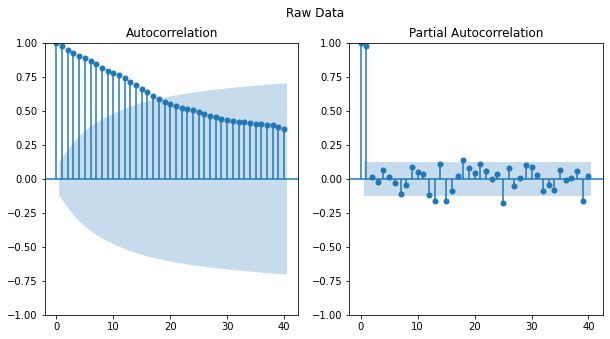

In [398]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(ts.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(ts.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

In [399]:
# 1차 차분 및 데이터 확인

diff_1 = df.copy()
diff_1 = diff_1['Close'].diff()
diff_1 = diff_1.dropna()
print('####### Raw Data ######')
print(ts)
print('\n####### 1st Differenced Data ######')
print(diff_1)
print('\n')
augmented_dickey_fuller_test(diff_1)

# 2차 차분 및 차분데이터 확인
diff_2 = diff_1.diff()
diff_2 = diff_2.dropna()
print('\n####### 2dn Differenced Data ######')
print(diff_2)
print('\n')
print(augmented_dickey_fuller_test(diff_2))

####### Raw Data ######
Date
2021-02-16    9.550200
2021-02-17    9.544345
2021-02-18    9.537149
2021-02-19    9.537805
2021-02-22    9.512890
                ...   
2022-02-09    9.581240
2022-02-10    9.559985
2022-02-11    9.531782
2022-02-14    9.531766
2022-02-15    9.556746
Name: Close, Length: 254, dtype: float64

####### 1st Differenced Data ######
Date
2021-02-17    -82.009766
2021-02-18   -100.129882
2021-02-19      9.099609
2021-02-22   -341.410156
2021-02-23    -67.849610
                 ...    
2022-02-09    295.919922
2022-02-10   -304.730469
2022-02-11   -394.489257
2022-02-14     -0.230469
2022-02-15    348.839844
Name: Close, Length: 253, dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.627034e+01
p-value                        3.493151e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)  

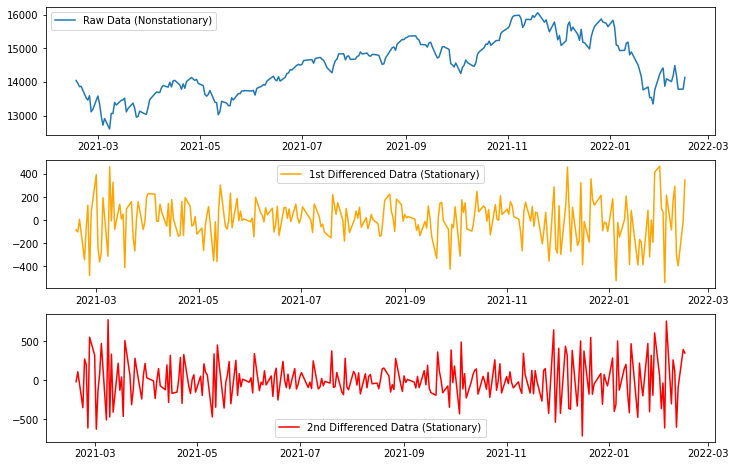

In [400]:
# 차분 데이터 시각화
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(df['Close'])
plt.legend(['Raw Data (Nonstationary)'])

plt.subplot(312)
plt.plot(diff_1, 'orange') # first difference (t - (t-1))
plt.legend(['1st Differenced Datra (Stationary)'])

plt.subplot(313)
plt.plot(diff_2, 'red') # first difference (t - (t-2))
plt.legend(['2nd Differenced Datra (Stationary)'])

plt.show()

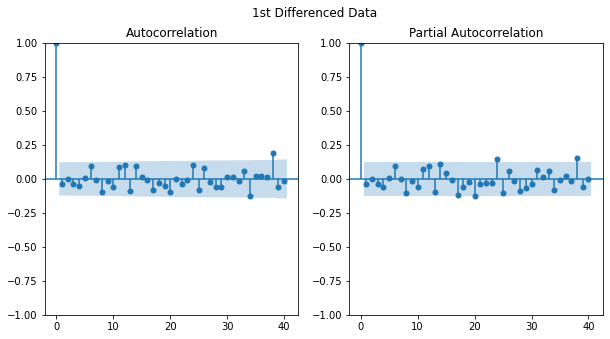

In [401]:
# 1차 차분 데이터의 ACF, PACF 그래프

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('1st Differenced Data')
sm.graphics.tsa.plot_acf(diff_1.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(diff_1.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

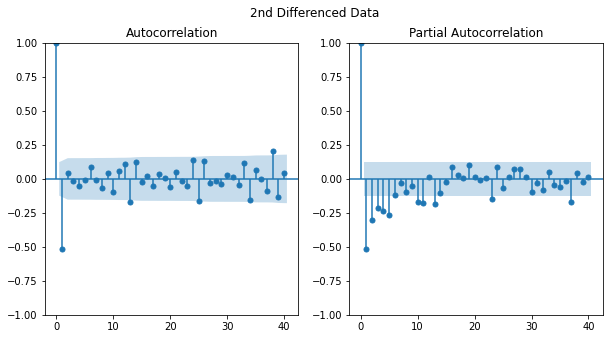

In [402]:
# 2차 차분 데이터의 ACF, PACF 그래프

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('2nd Differenced Data')
sm.graphics.tsa.plot_acf(diff_2.squeeze(), lags=40, ax=ax[0])   # ACF : Autocorrelation 그래프 그리기
sm.graphics.tsa.plot_pacf(diff_2.squeeze(), lags=40, ax=ax[1]);  # PACF : Partial Autocorrelation 그래프 그리기

In [413]:
# auto arima model을 사용한 최적 파라메터 찾기
auto_arima_model = auto_arima(train_data, start_p=0, start_q=0,
                              max_p=2, max_q=2, seasonal=False,
                              d=2,
                              trace=True,
                              eooro_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1202.496, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1352.986, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1275.103, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1302.995, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-1362.127, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0] intercept
Total fit time: 1.987 seconds


In [409]:
# auto_arima_model 의 요약 
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(0, 5, 4)   Log Likelihood                 632.335
Date:                Thu, 17 Feb 2022   AIC                          -1254.670
Time:                        13:13:40   BIC                          -1237.635
Sample:                             0   HQIC                         -1247.793
                                - 228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -3.8815      0.053    -72.663      0.000      -3.986      -3.777
ma.L2          5.6940      0.155     36.656      0.000       5.390       5.998
ma.L3         -3.7420      0.153    -24.505      0.000      -4.041      -3.443
ma.L4          0.9296      0.051     18.324      0.000       0.830       1.029
sigma2         0.0002   1.74e-05      9.915      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.13   Prob(JB):                         0.65
Heteroskedasticity (H):               0.70   Skew:                             0.14
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [414]:
# Build Model

from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(train_data, order=(2, 2, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 686.995
Date:                Thu, 17 Feb 2022   AIC                          -1365.990
Time:                        13:14:46   BIC                          -1352.308
Sample:                             0   HQIC                         -1360.468
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0671      0.068     -0.987      0.323      -0.200       0.066
ar.L2         -0.0068      0.049     -0.139      0.889      -0.102       0.089
ma.L1         -0.9969      0.112     -8.882      0.0

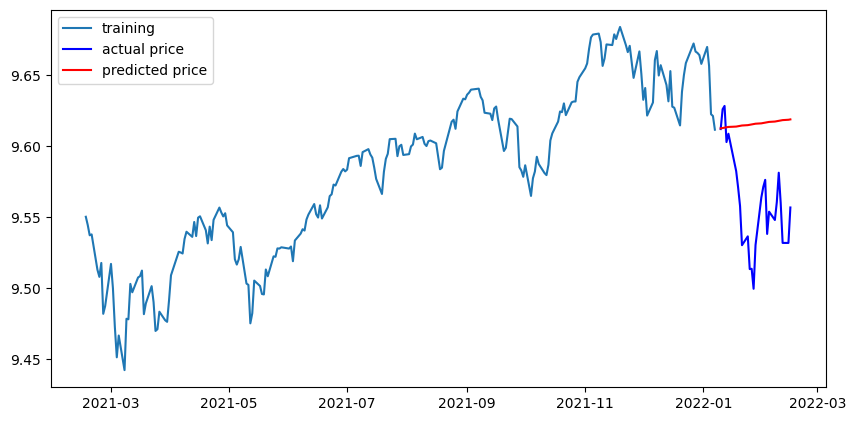

In [415]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [416]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  873800.2246663092
MAE:  822.6883685250369
RMSE:  934.772819815761
MAPE: 5.90%


Nasdaq분석은 내가 직접 패턴을 분석해서 진행한 것과 조금 다른 패턴을 찾았지만 결과는 0.03% 정도 개선되는 것을 보여주었다.

## 최종결론 
auto_arima_model이 최적의 모델을 뽑아 주는 만능 기계는 아니라는 결론을 내렸다. 
어느정도 사람이 차분 그래프의 패턴을 분석하고 그 데이터를 기반으로 조정하는 것이 더 좋은 효과를 낼 수 있음을 확인했다.
SARIMA 모델을 사용하여 seasonal 파라메터도 계산하여 진행하고 싶었지만 시간상 그렇게 하지 못했다. 
기회가 된다면 SARIMA 모델을 사용해서 조금더 정확한 예측을 할 계획이다. 
이번 익스플로레이션을 통해서 시계열 데이터와 ARIMA model에 대해서 매우 자세하게 공부 할 수 있었던 계기가 된것 같아서 뿌듯하다.

## 이제 진짜 끝